In [1]:
import random
import pandas as pd
import sys
import re
import numpy as np
import matplotlib.pyplot as plt 
import numpy_indexed as npi
import statsmodels.api as sm
import pylab
from textblob import TextBlob 
import seaborn as sns
plt.style.use('seaborn')

C:\Users\Sourish\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
raw = pd.read_csv("D:/LIWC2015.csv")

In [3]:
filtered_samp = raw[(raw.useful>=1) & (raw.useful <= 30)]
raw.head()
raw.columns

Index(['text', 'useful', 'cool', 'funny', 'date', 'WC', 'Analytic', 'Clout',
       'Authentic', 'Tone', 'WPS', 'Sixltr', 'Dic', 'function', 'pronoun',
       'ppron', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep',
       'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare',
       'interrog', 'number', 'quant', 'affect', 'posemo', 'negemo', 'anx',
       'anger', 'sad', 'social', 'family', 'friend', 'female', 'male',
       'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ',
       'percept', 'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual',
       'ingest', 'drives', 'affiliation', 'achieve', 'power', 'reward', 'risk',
       'focuspast', 'focuspresent', 'focusfuture', 'relativ', 'motion',
       'space', 'time', 'work', 'leisure', 'home', 'money', 'relig', 'death',
       'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler',
       'AllPunc', 'Period', 'Comma', 'Colon', 'SemiC', 'QMark', 'Exclam',
       'Dash', 'Quote

In [4]:
# Seperating the date you we can manipulate and split into sub-components
dates_list = []

# The new column variables we will soon add to our filtered data frame
month_list = []
year_list = []
day_list = []
time_list = []

for dates in filtered_samp["date"]:
    dates_list.append(dates)

for full_date in dates_list:
    month = float(full_date.split("-")[1])
    month_list.append(month)

    year = float(full_date.split("-")[0])
    year_list.append(year)
    
    # Since the day has a time attached to it by a space we need to also split at the space
    day_with_time = full_date.split("-")[2]
    day = float(day_with_time.split(" ")[0])    
    day_list.append(day)
    
    # Looking at time need to do something similar to day
    date_with_time = full_date.split("-")[2]
    time = date_with_time.split(" ")[1]
    hour = time.split(":")[0]
    time_list.append(float(hour))
    
# Allows us to work with a filtered copy of the sample and make changes to it as now it is in a different state
df2 = filtered_samp.copy(deep=False)
df2["month"] = np.array(month_list)
df2["year"] = np.array(year_list)
df2["day"] = np.array(day_list)
df2["hour"] = np.array(time_list)

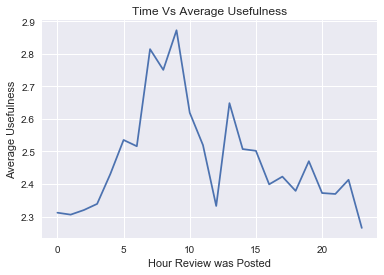

In [5]:
x_hours, y_usefulness_avg = npi.group_by(df2.hour).mean(df2.useful)

sns.lineplot(x_hours, y_usefulness_avg)
plt.title('Time Vs Average Usefulness')
plt.xlabel('Hour Review was Posted')
plt.ylabel('Average Usefulness')
plt.savefig("Time_series_Hour.png", dpi = 300)

plt.show()

from sklearn.cluster import KMeans

X = np.array(list(zip(x_hours, y_usefulness_avg)))



# Aggregate summary

In [6]:
df2_text_f = df2

df2t = df2_text_f["text"]


count_breakfast = 0
count_brunch = 0
count_lunch = 0
count_dinner = 0
count_date = 0
count_price = 0
count_positive = 0
count_negative = 0
count_neutral = 0
bias_count = 0 



for index in range(0,len(df2t)):
    if "dinner" in df2t.iloc[index].lower():
        count_dinner += 1
    elif "lunch" in df2t.iloc[index].lower():
        count_lunch += 1
    elif "breakfast" in df2t.iloc[index].lower():
        count_breakfast += 1
    elif "brunch" in df2t.iloc[index].lower():
        count_brunch += 1
    elif "date" in df2t.iloc[index].lower():
        count_date += 1
    elif "price" or "cost" or "expensive" or "$" or "dollar" in df2t.iloc[index].lower():
        count_price += 1

sentiment_df = df2t[:].apply(lambda x: TextBlob(x).sentiment)
    
for index in range(0,len(sentiment_df)):
    sentiments = sentiment_df.iloc[index][0]
    if sentiments > 0:
        count_positive += 1
    elif sentiments < 0:
        count_negative += 1
    elif sentiments == 0:
        count_neutral += 1
    
    subjectivity = sentiment_df.iloc[index][1]
    if subjectivity > 0.5:
        bias_count += 1


print("Type of meal count")
print(100*count_dinner/len(df2t))
print(100*count_lunch/len(df2t))
print(100*count_breakfast/len(df2t))
print(100*count_brunch/len(df2t))

print("Spike words")

print("\n"+ str(100*count_date/len(df2t)))
print(str(100*count_price/len(df2t)))

print("\n"+"Sentiment Analysis")

print(100*count_positive/len(df2t))
print(100*count_negative/len(df2t))
print(100*count_neutral/len(df2t))
print(100*bias_count/len(df2t))


#LIWC component
summary = pd.DataFrame(["Mean", "Median"])

for columns in df2_text_f.columns:
    if pd.api.types.is_numeric_dtype(df2_text_f[columns]):
        summary[columns] = pd.Series([df2_text_f[columns].mean(),df2_text_f[columns].median()])
print(summary)

Type of meal count
11.137629276054097
8.662080584023586
3.870092189620478
1.3383873835930553
Spike words

3.2008984978239505
71.79091206888484

Sentiment Analysis
86.47807571716038
12.84805091487669
0.673873367962937
71.58032664139641
        0    useful      cool    funny          WC   Analytic      Clout  \
0    Mean  2.414315  1.105854  0.86333  140.435537  57.728381  50.996118   
1  Median  1.000000  0.000000  0.00000  106.000000  59.825000  50.000000   

   Authentic       Tone     WPS  ...    Exclam      Dash     Quote   Apostro  \
0   46.40221  76.055581  13.872  ...  1.664949  0.657327  0.283382  1.990334   
1   44.46500  92.000000  12.910  ...  0.245000  0.000000  0.000000  1.670000   

    Parenth    OtherP     month         year        day      hour  
0  0.712597  0.587736  6.354322  2014.479409  15.741424  12.09591  
1  0.000000  0.000000  6.000000  2015.000000  16.000000  15.00000  

[2 rows x 101 columns]


# Look for differences in time periods

Breakfast(7am-11am)

In [7]:
df2_text_f1 = df2[(df2.hour >= 7) & (df2.hour <= 11)]

df2t = df2_text_f1["text"]


count_breakfast = 0
count_brunch = 0
count_lunch = 0
count_dinner = 0
count_date = 0
count_price = 0
count_positive = 0
count_negative = 0
count_neutral = 0
bias_count = 0 



for index in range(0,len(df2t)):
    if "dinner" in df2t.iloc[index].lower():
        count_dinner += 1
    elif "lunch" in df2t.iloc[index].lower():
        count_lunch += 1
    elif "breakfast" in df2t.iloc[index].lower():
        count_breakfast += 1
    elif "brunch" in df2t.iloc[index].lower():
        count_brunch += 1
    elif "date" in df2t.iloc[index].lower():
        count_date += 1
    elif "price" or "cost" or "expensive" or "$" or "dollar" in df2t.iloc[index].lower():
        count_price += 1

sentiment_df = df2t[:].apply(lambda x: TextBlob(x).sentiment)
    
for index in range(0,len(sentiment_df)):
    sentiments = sentiment_df.iloc[index][0]
    if sentiments > 0:
        count_positive += 1
    elif sentiments < 0:
        count_negative += 1
    elif sentiments == 0:
        count_neutral += 1
    
    subjectivity = sentiment_df.iloc[index][1]
    if subjectivity > 0.5:
        bias_count += 1


print("Type of meal count")
print(100*count_dinner/len(df2t))
print(100*count_lunch/len(df2t))
print(100*count_breakfast/len(df2t))
print(100*count_brunch/len(df2t))

print("Spike words")

print("\n"+ str(100*count_date/len(df2t)))
print(str(100*count_price/len(df2t)))

print("\n"+"Sentiment Analysis")

print(100*count_positive/len(df2t))
print(100*count_negative/len(df2t))
print(100*count_neutral/len(df2t))
print(100*bias_count/len(df2t))


#LIWC component
summary1 = pd.DataFrame(["Mean", "Median"])

for columns in df2_text_f1.columns:
    if pd.api.types.is_numeric_dtype(df2_text_f1[columns]):
        summary1[columns] = pd.Series([df2_text_f1[columns].mean(),df2_text_f1[columns].median()])
print(summary1)

Type of meal count
11.90578158458244
6.552462526766595
3.0835117773019274
0.728051391862955
Spike words

3.554603854389722
74.17558886509636

Sentiment Analysis
84.02569593147751
15.460385438972162
0.5139186295503212
71.13490364025697
        0    useful      cool     funny          WC   Analytic      Clout  \
0    Mean  2.744325  1.446681  1.173019  159.868522  57.079649  49.875683   
1  Median  2.000000  1.000000  0.000000  116.000000  59.200000  50.000000   

   Authentic       Tone        WPS  ...    Exclam      Dash    Quote  \
0  47.568985  74.208724  14.603456  ...  1.787161  0.646591  0.32373   
1  46.400000  89.570000  13.380000  ...  0.290000  0.000000  0.00000   

    Apostro   Parenth    OtherP    month         year        day      hour  
0  2.055002  0.722274  0.617966  6.31349  2014.158887  15.984582  8.437259  
1  1.790000  0.000000  0.000000  6.00000  2015.000000  16.000000  8.000000  

[2 rows x 101 columns]


Lunch(12PM - 5PM)

In [8]:
df2_text_f2 = df2[(df2.hour >= 12) & (df2.hour <= 17)]

df2t = df2_text_f2["text"]


count_breakfast = 0
count_brunch = 0
count_lunch = 0
count_dinner = 0
count_date = 0
count_price = 0
count_positive = 0
count_negative = 0
count_neutral = 0
bias_count = 0 



for index in range(0,len(df2t)):
    if "dinner" in df2t.iloc[index].lower():
        count_dinner += 1
    elif "lunch" in df2t.iloc[index].lower():
        count_lunch += 1
    elif "breakfast" in df2t.iloc[index].lower():
        count_breakfast += 1
    elif "brunch" in df2t.iloc[index].lower():
        count_brunch += 1
    elif "date" in df2t.iloc[index].lower():
        count_date += 1
    elif "price" or "cost" or "expensive" or "$" or "dollar" in df2t.iloc[index].lower():
        count_price += 1

sentiment_df = df2t[:].apply(lambda x: TextBlob(x).sentiment)
    
for index in range(0,len(sentiment_df)):
    sentiments = sentiment_df.iloc[index][0]
    if sentiments > 0:
        count_positive += 1
    elif sentiments < 0:
        count_negative += 1
    elif sentiments == 0:
        count_neutral += 1
    
    subjectivity = sentiment_df.iloc[index][1]
    if subjectivity > 0.5:
        bias_count += 1


print("Type of meal count")
print(100*count_dinner/len(df2t))
print(100*count_lunch/len(df2t))
print(100*count_breakfast/len(df2t))
print(100*count_brunch/len(df2t))

print("\n Spike words")

print(str(100*count_date/len(df2t)))
print(str(100*count_price/len(df2t)))

print("\n"+"Sentiment Analysis")

print(100*count_positive/len(df2t))
print(100*count_negative/len(df2t))
print(100*count_neutral/len(df2t))
print(100*bias_count/len(df2t))

#LIWC component
summary2 = pd.DataFrame(["Mean", "Median"])

for columns in df2_text_f2.columns:
    if pd.api.types.is_numeric_dtype(df2_text_f2[columns]):
        summary2[columns] = pd.Series([df2_text_f2[columns].mean(),df2_text_f2[columns].median()])
print(summary2)

Type of meal count
12.220877791222089
9.261907380926191
5.5109448905510945
1.5949840501594985

 Spike words
3.2889671103288967
68.12231877681224

Sentiment Analysis
88.5821141788582
10.801891981080189
0.6159938400615994
72.35727642723573
        0    useful      cool     funny         WC  Analytic      Clout  \
0    Mean  2.463095  1.140799  0.867451  147.97866  59.00646  51.330333   
1  Median  2.000000  1.000000  0.000000  114.00000  61.30000  50.000000   

   Authentic       Tone        WPS  ...    Exclam     Dash     Quote  \
0  46.562564  77.305872  14.072908  ...  1.430159  0.72631  0.293976   
1  44.790000  92.400000  13.200000  ...  0.000000  0.00000  0.000000   

    Apostro   Parenth    OtherP     month         year        day       hour  
0  1.994887  0.755092  0.584606  6.444286  2014.429106  15.799692  15.250687  
1  1.670000  0.000000  0.000000  6.000000  2015.000000  16.000000  16.000000  

[2 rows x 101 columns]


Dinner (6PM-11PM)

In [9]:
df2_text_f3 = df2[(df2.hour >= 6) & (df2.hour <= 11)]

df2t = df2_text_f3["text"]


count_breakfast = 0
count_brunch = 0
count_lunch = 0
count_dinner = 0
count_date = 0
count_price = 0
count_positive = 0
count_negative = 0
count_neutral = 0
bias_count = 0 



for index in range(0,len(df2t)):
    if "dinner" in df2t.iloc[index].lower():
        count_dinner += 1
    elif "lunch" in df2t.iloc[index].lower():
        count_lunch += 1
    elif "breakfast" in df2t.iloc[index].lower():
        count_breakfast += 1
    elif "brunch" in df2t.iloc[index].lower():
        count_brunch += 1
    elif "date" in df2t.iloc[index].lower():
        count_date += 1
    elif "price" or "cost" or "expensive" or "$" or "dollar" in df2t.iloc[index].lower():
        count_price += 1

sentiment_df = df2t[:].apply(lambda x: TextBlob(x).sentiment)
    
for index in range(0,len(sentiment_df)):
    sentiments = sentiment_df.iloc[index][0]
    if sentiments > 0:
        count_positive += 1
    elif sentiments < 0:
        count_negative += 1
    elif sentiments == 0:
        count_neutral += 1
    
    subjectivity = sentiment_df.iloc[index][1]
    if subjectivity > 0.5:
        bias_count += 1


print("Type of meal count")
print(100*count_dinner/len(df2t))
print(100*count_lunch/len(df2t))
print(100*count_breakfast/len(df2t))
print(100*count_brunch/len(df2t))

print("\n"+"Spike words")
print(str(100*count_date/len(df2t)))
print(str(100*count_price/len(df2t)))

print("\n"+"Sentiment Analysis")

print(100*count_positive/len(df2t))
print(100*count_negative/len(df2t))
print(100*count_neutral/len(df2t))
print(100*bias_count/len(df2t))

#LIWC component
summary3 = pd.DataFrame(["Mean", "Median"])

for columns in df2_text_f3.columns:
    if pd.api.types.is_numeric_dtype(df2_text_f3[columns]):
        summary3[columns] = pd.Series([df2_text_f3[columns].mean(),df2_text_f3[columns].median()])
print(summary3)

Type of meal count
12.205506670451319
6.329832529094522
3.0939540164632415
0.8799318762418393

Spike words
3.5481124042009653
73.9426625035481

Sentiment Analysis
84.44507521998297
14.873687198410446
0.6812375816065853
70.96224808401931
        0    useful     cool     funny          WC   Analytic      Clout  \
0    Mean  2.667329  1.34885  1.076923  156.300312  57.031232  50.159909   
1  Median  2.000000  1.00000  0.000000  116.000000  58.950000  50.000000   

   Authentic       Tone        WPS  ...    Exclam      Dash     Quote  \
0  47.497647  74.100423  14.391368  ...  1.782109  0.650213  0.307865   
1  46.130000  89.840000  13.250000  ...  0.330000  0.000000  0.000000   

    Apostro   Parenth    OtherP   month         year        day      hour  
0  2.048269  0.717658  0.600099  6.2935  2014.179676  15.948623  7.615385  
1  1.790000  0.000000  0.000000  6.0000  2015.000000  16.000000  7.000000  

[2 rows x 101 columns]


Pub (12AM-6AM)

In [10]:
df2_text_f4 = df2[(df2.hour >= 0) & (df2.hour <= 6)].append(df2[(df2.hour >= 0) & (df2.hour <= 2)])


df2t = df2_text_f4["text"]


count_breakfast = 0
count_brunch = 0
count_lunch = 0
count_dinner = 0
count_date = 0
count_price = 0
count_positive = 0
count_negative = 0
count_neutral = 0
bias_count = 0 



for index in range(0,len(df2t)):
    if "dinner" in df2t.iloc[index].lower():
        count_dinner += 1
    elif "lunch" in df2t.iloc[index].lower():
        count_lunch += 1
    elif "breakfast" in df2t.iloc[index].lower():
        count_breakfast += 1
    elif "brunch" in df2t.iloc[index].lower():
        count_brunch += 1
    elif "date" in df2t.iloc[index].lower():
        count_date += 1
    elif "price" or "cost" or "expensive" or "$" or "dollar" in df2t.iloc[index].lower():
        count_price += 1

sentiment_df = df2t[:].apply(lambda x: TextBlob(x).sentiment)
    
for index in range(0,len(sentiment_df)):
    sentiments = sentiment_df.iloc[index][0]
    if sentiments > 0:
        count_positive += 1
    elif sentiments < 0:
        count_negative += 1
    elif sentiments == 0:
        count_neutral += 1
    
    subjectivity = sentiment_df.iloc[index][1]
    if subjectivity > 0.5:
        bias_count += 1


print("Type of meal count")
print(100*count_dinner/len(df2t))
print(100*count_lunch/len(df2t))
print(100*count_breakfast/len(df2t))
print(100*count_brunch/len(df2t))

print("\n"+"Spike words")
print(str(100*count_date/len(df2t)))
print(str(100*count_price/len(df2t)))

print("\n"+"Sentiment Analysis")

print(100*count_positive/len(df2t))
print(100*count_negative/len(df2t))
print(100*count_neutral/len(df2t))
print(100*bias_count/len(df2t))

#LIWC component
summary4 = pd.DataFrame(["Mean", "Median"])

for columns in df2_text_f4.columns:
     if pd.api.types.is_numeric_dtype(df2_text_f4[columns]):
        summary4[columns] = pd.Series([df2_text_f4[columns].mean(),df2_text_f4[columns].median()])
print(summary4)

Type of meal count
11.260087424344317
6.998150638870208
2.8496973772696705
1.1894754539340955

Spike words
3.1817417619367854
74.52084734364492

Sentiment Analysis
85.53295225285811
13.6726630800269
0.7943846671149967
71.45679219905851
        0   useful      cool     funny          WC   Analytic      Clout  \
0    Mean  2.35306  1.058255  0.818258  133.084104  57.107746  51.121571   
1  Median  1.00000  0.000000  0.000000  101.000000  59.170000  50.000000   

   Authentic       Tone        WPS  ...    Exclam      Dash     Quote  \
0  45.776094  75.599784  13.534036  ...  1.787911  0.634781  0.281053   
1  43.370000  92.365000  12.600000  ...  0.260000  0.000000  0.000000   

    Apostro   Parenth    OtherP     month         year        day      hour  
0  1.969619  0.701632  0.578622  6.309053  2014.580825  15.602766  2.080657  
1  1.640000  0.000000  0.000000  6.000000  2015.000000  16.000000  2.000000  

[2 rows x 101 columns]


# Mean

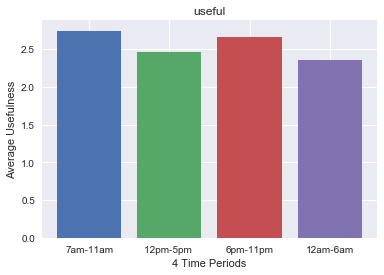

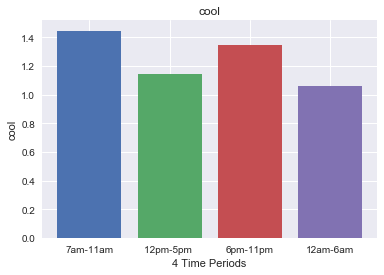

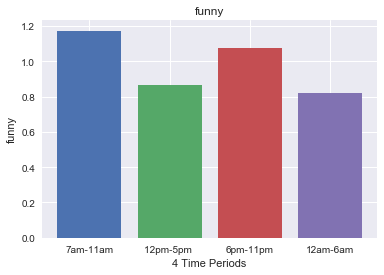

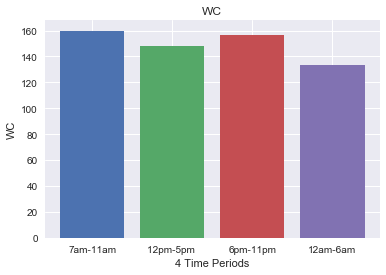

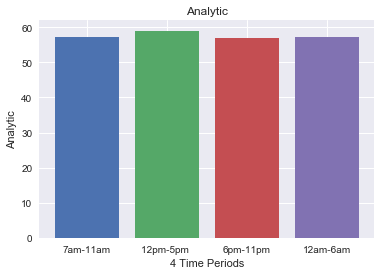

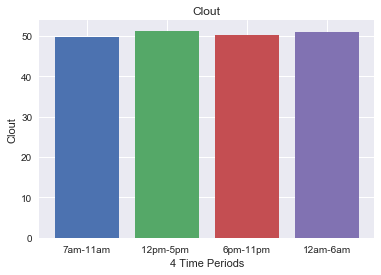

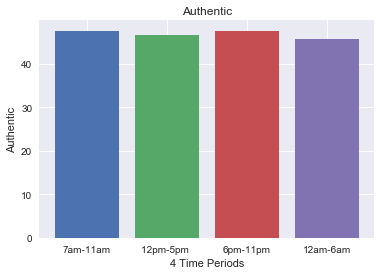

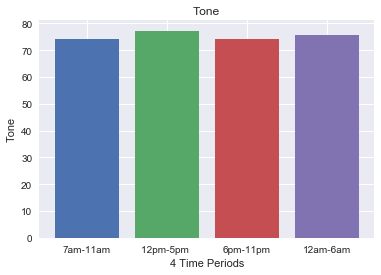

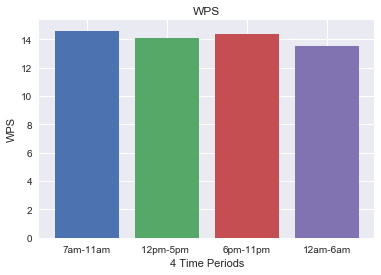

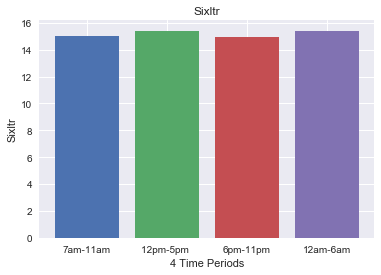

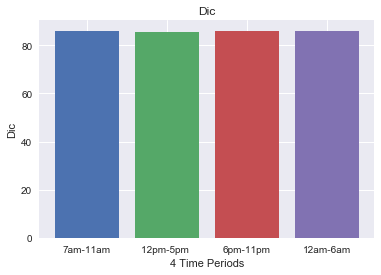

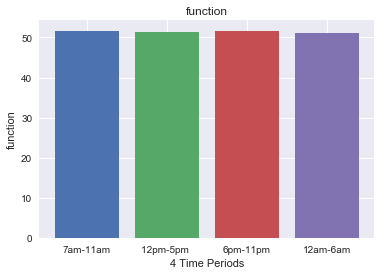

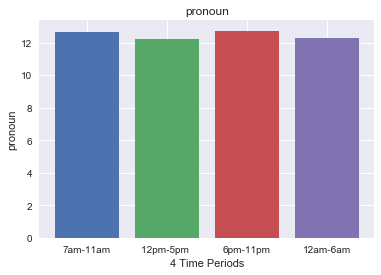

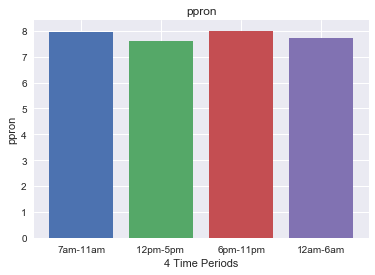

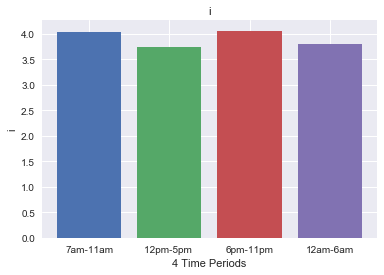

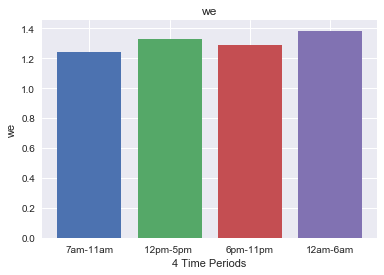

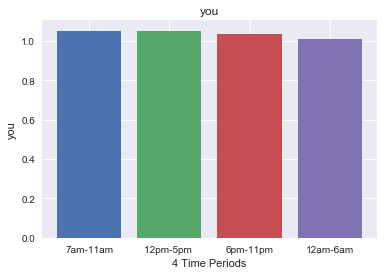

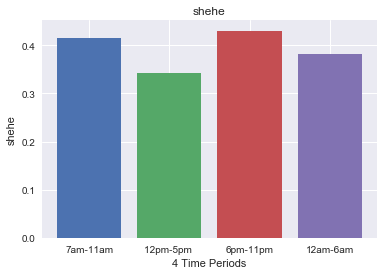

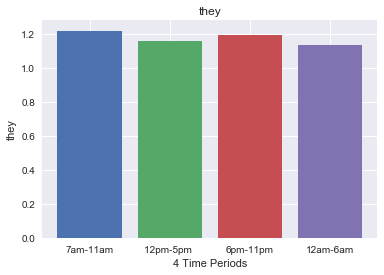

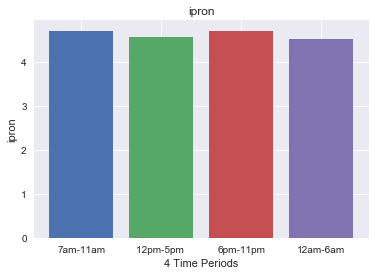

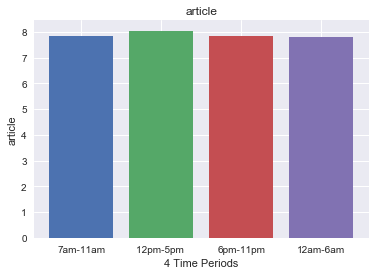

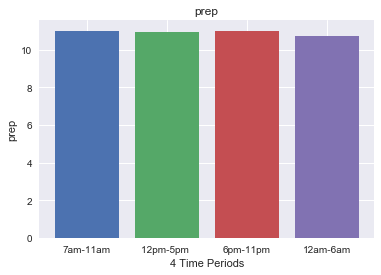

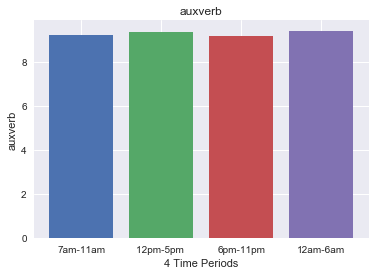

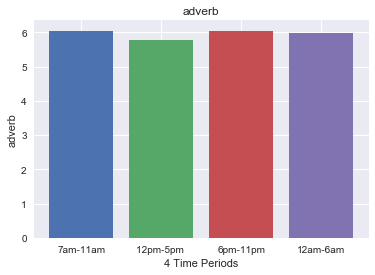

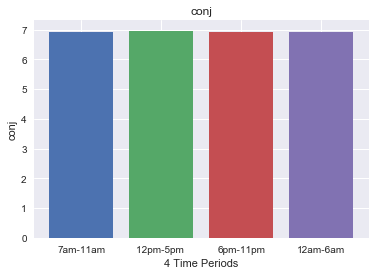

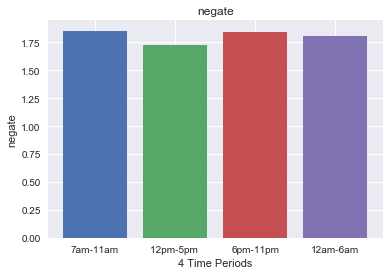

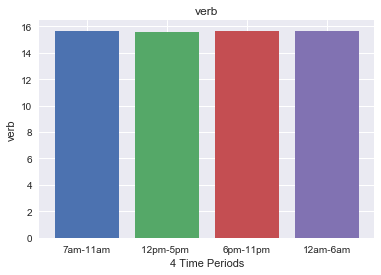

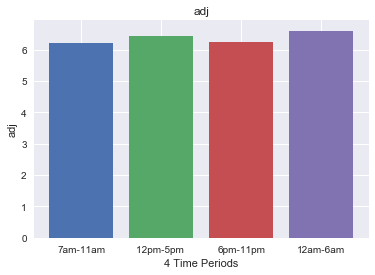

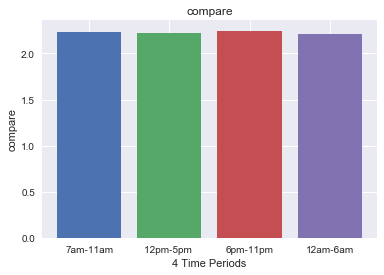

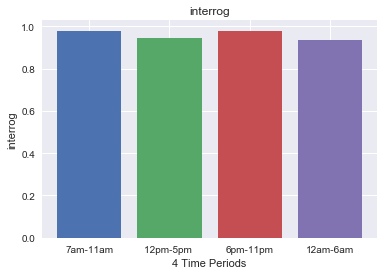

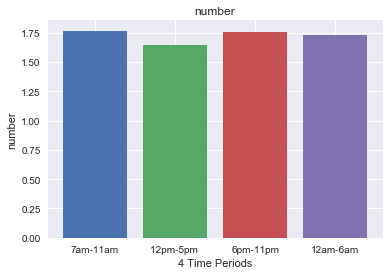

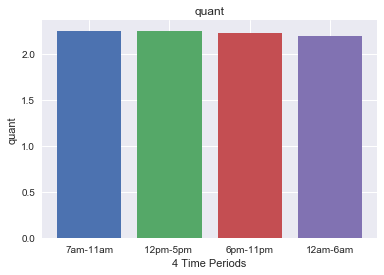

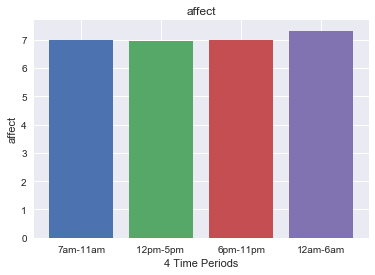

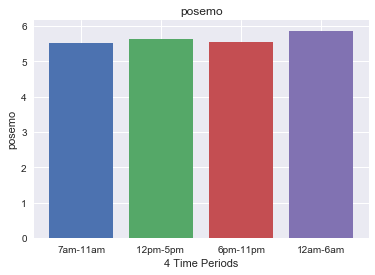

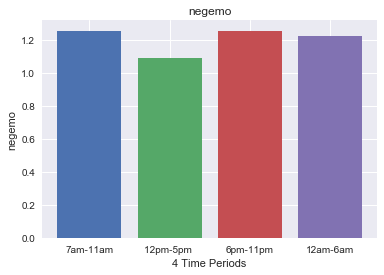

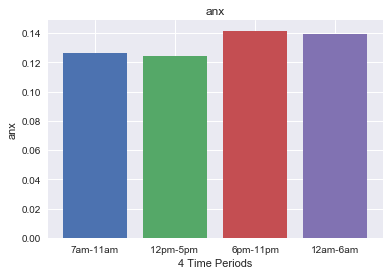

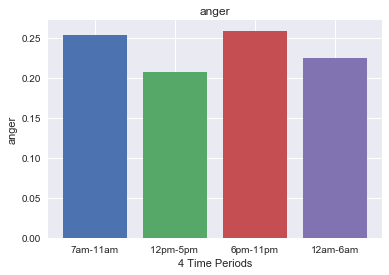

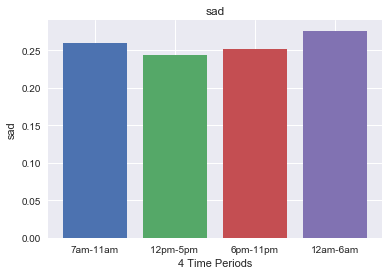

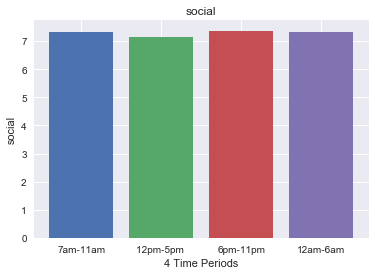

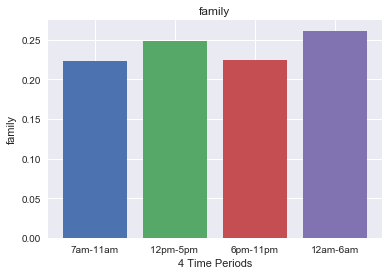

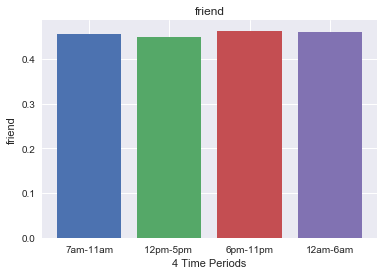

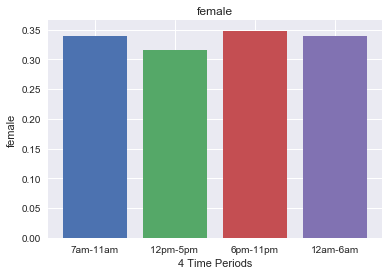

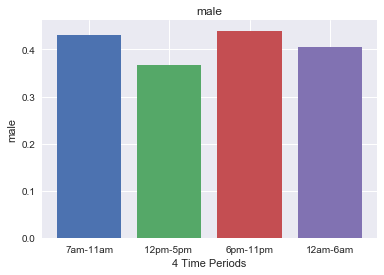

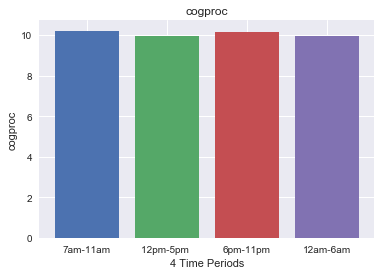

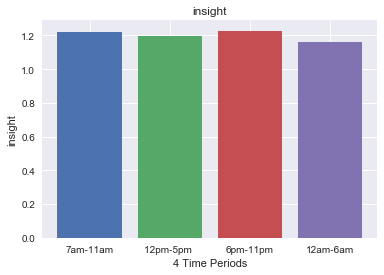

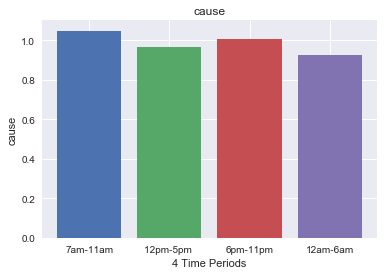

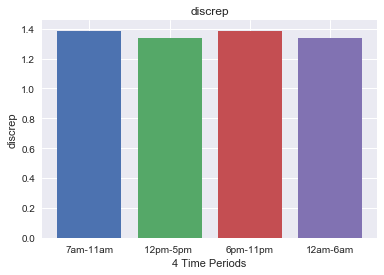

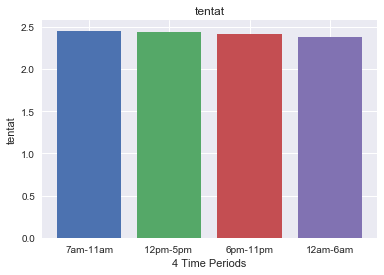

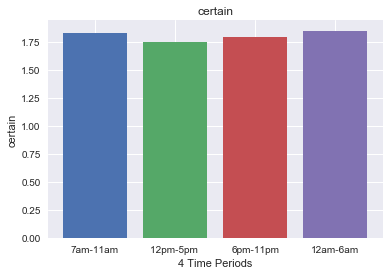

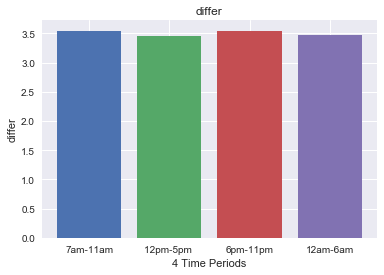

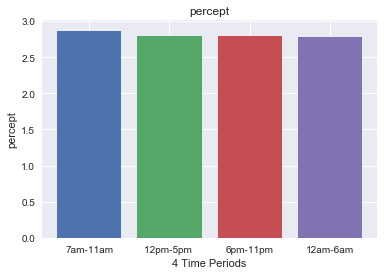

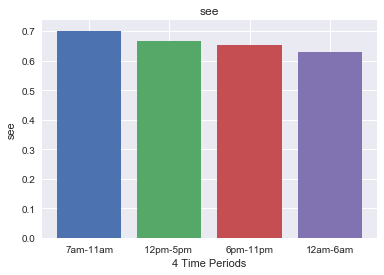

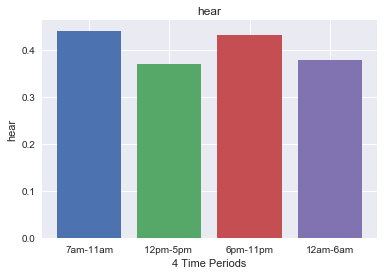

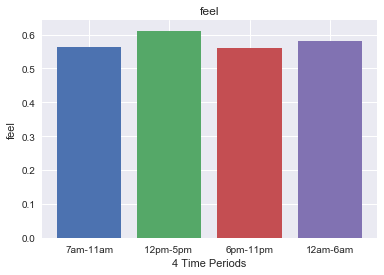

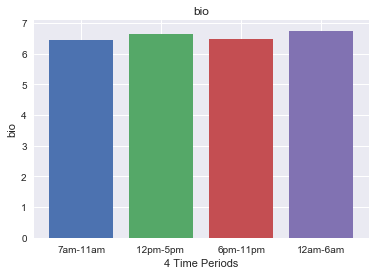

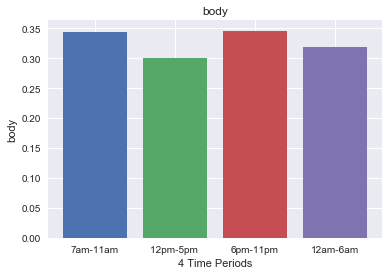

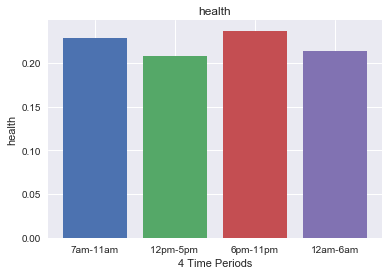

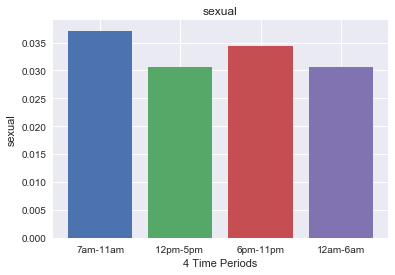

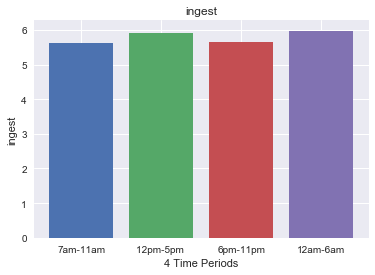

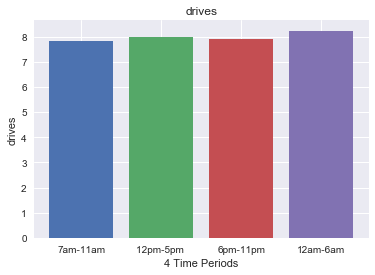

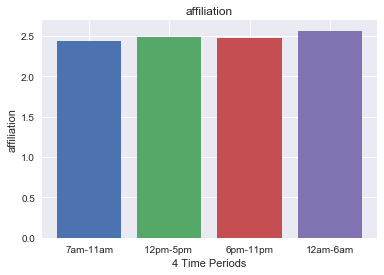

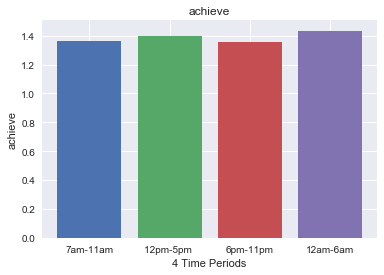

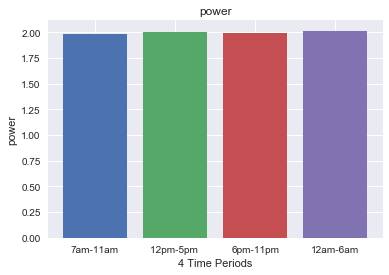

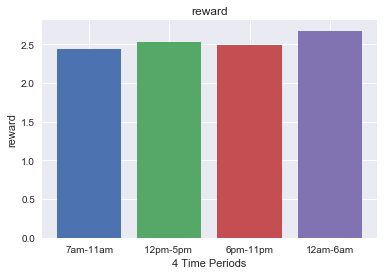

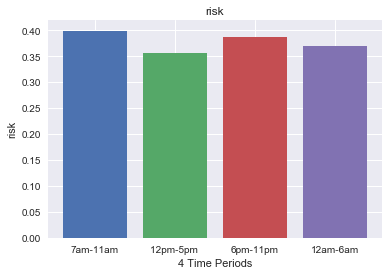

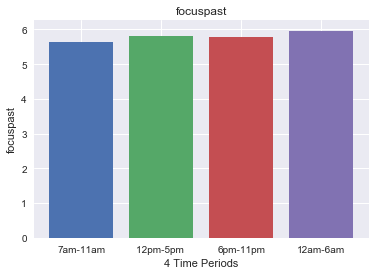

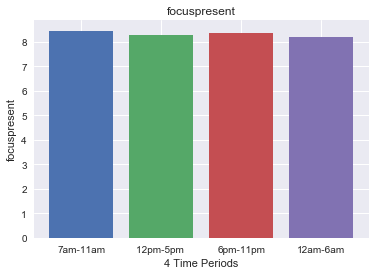

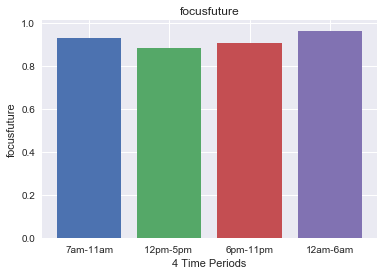

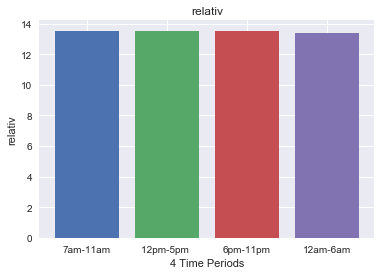

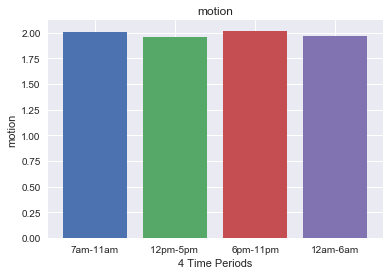

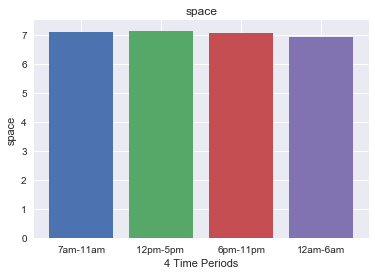

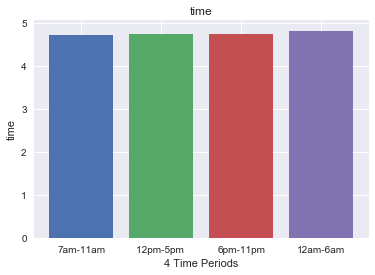

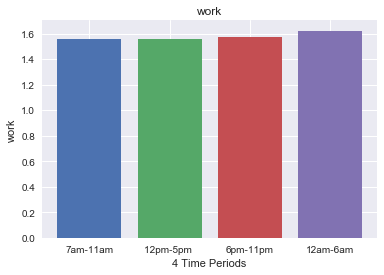

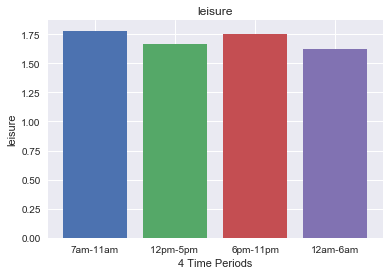

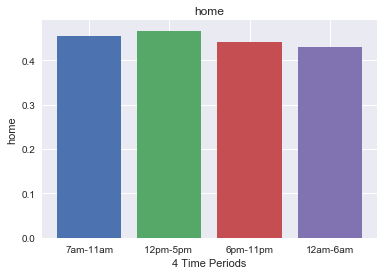

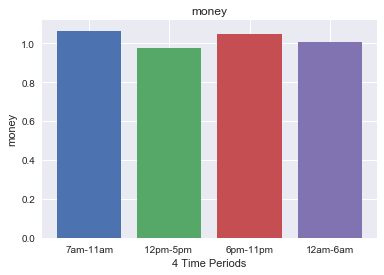

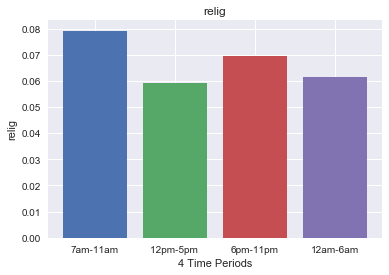

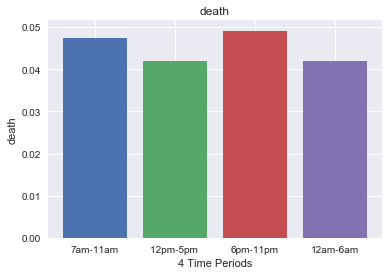

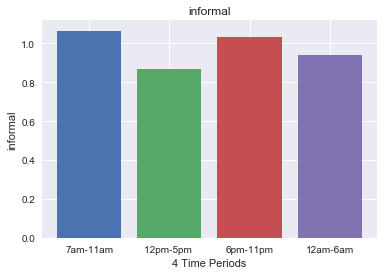

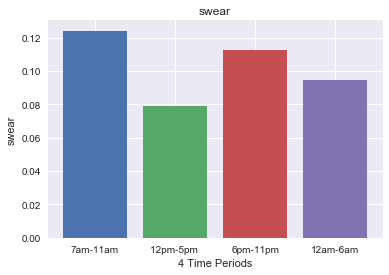

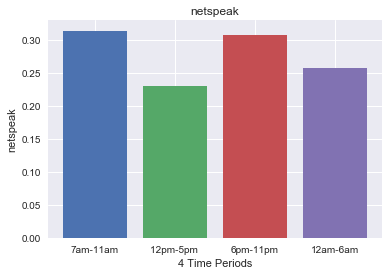

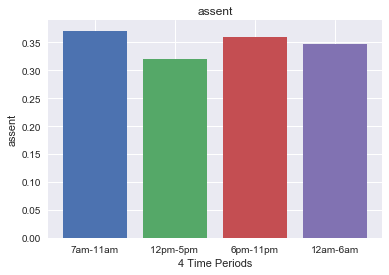

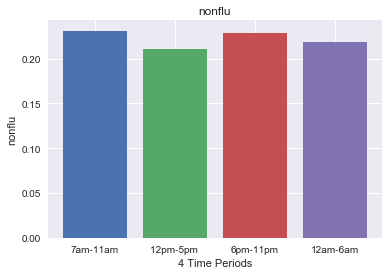

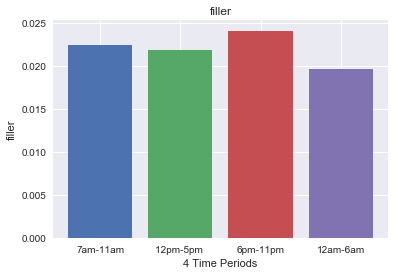

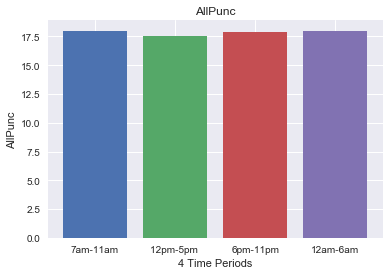

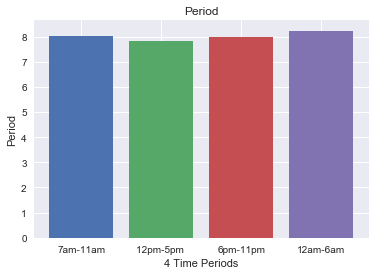

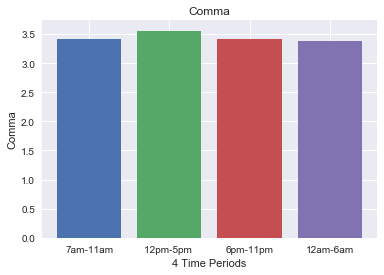

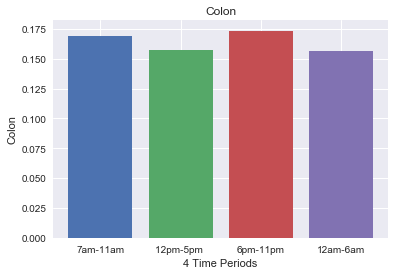

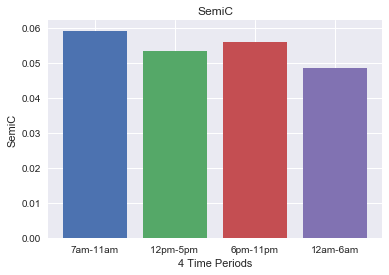

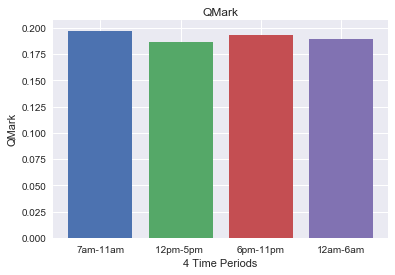

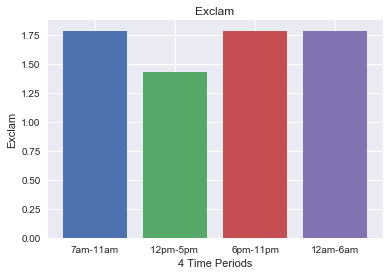

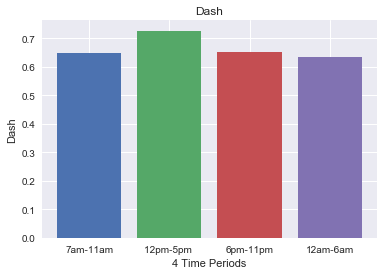

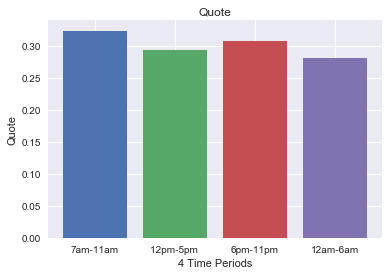

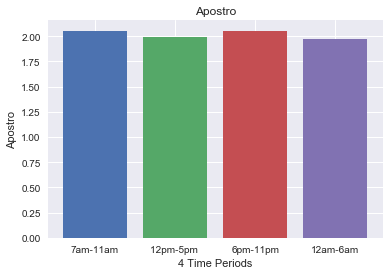

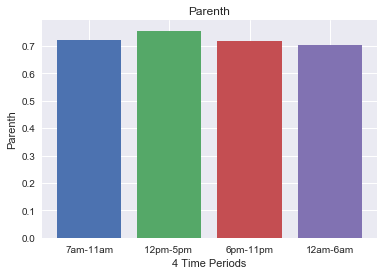

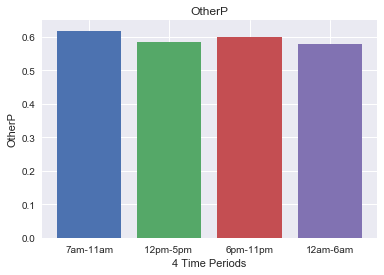

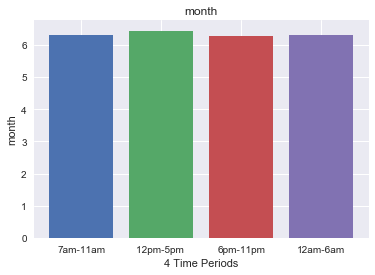

In [11]:
for column_index in range(0,len(summary1.columns)):
    if (column_index == 0) or (column_index == 98) or (column_index == 99) or (column_index == 100) :
        pass
    else:
        plt.bar("7am-11am", summary1.iloc[0,column_index])
        plt.bar("12pm-5pm ", summary2.iloc[0,column_index])
        plt.bar("6pm-11pm", summary3.iloc[0,column_index])
        plt.bar("12am-6am", summary4.iloc[0,column_index])
        
        
        plt.title(summary1.columns[column_index])
        if (summary1.columns[column_index] == "useful"):
            plt.ylabel("Average Usefulness")
        else:
            plt.ylabel(summary1.columns[column_index])
        plt.xlabel("4 Time Periods")
        
        if (summary1.columns[column_index] == "cool") or (summary1.columns[column_index] == "funny") or (summary1.columns[column_index] == "useful"):
            plt.savefig(str(summary1.columns[column_index])+".png", dpi = 600)
        plt.show()
        
        

# T- test

DF with groups 2,3 and 4

In [34]:
df_low_review = df2[(df2.hour >= 12) & (df2.hour <= 23)].append(df2[(df2.hour >= 0) & (df2.hour <= 5)])
df_low_useful = np.array(df_low_review["useful"])

DF with groups 1 

In [35]:
df_high_review = df2[(df2.hour >= 7) & (df2.hour <= 11)]
df_high_useful = np.array(df_high_review["useful"])

In [36]:
from scipy import stats

stats.ttest_ind(df_low_useful, df_high_useful , axis=0, equal_var = False, nan_policy='propagate')

Ttest_indResult(statistic=-5.229668971769372, pvalue=1.837453578130565e-07)

# Finding Examples

In [12]:
df2_text_f1 = df2[(df2.hour >= 7) & (df2.hour <= 11)]

In [13]:
df2_text_f1[df2_text_f1.funny > 15]

,text,useful,cool,funny,date,WC,Analytic,Clout,Authentic,Tone,...,Exclam,Dash,Quote,Apostro,Parenth,OtherP,month,year,day,hour
13493,I imagine entering Hakkasan Nightclub to be li...,26.0,25,17.0,2016-03-30 08:27:19,386,70.35,70.69,97.34,39.68,...,0.26,1.30,0.00,4.66,0.52,0.00,3.0,2016.0,30.0,8.0
43020,If I could put zero stars I would. Food is ni...,7.0,4,16.0,2007-01-07 07:19:35,164,43.70,45.16,22.48,71.55,...,0.00,0.00,0.00,2.44,1.22,0.61,1.0,2007.0,7.0,7.0
43783,"I know what I saw on the Kim K sex tape, but w...",23.0,22,22.0,2017-12-26 10:53:39,192,45.87,37.72,45.44,97.42,...,0.00,1.04,0.00,1.56,0.00,0.00,12.0,2017.0,26.0,10.0
57492,Ok...Let's get this out of way right now! Any...,14.0,9,26.0,2014-06-13 08:53:10,488,50.72,54.88,46.61,75.25,...,2.66,0.00,0.00,2.66,0.00,0.41,6.0,2014.0,13.0,8.0
78589,You've heard the news. Read the stories. I bet...,30.0,29,25.0,2015-03-11 09:00:33,195,7.08,35.96,72.65,64.65,...,0.00,0.51,0.00,8.21,0.00,0.51,3.0,2015.0,11.0,9.0
80223,Meeting Yelpers from out of town is kind of fu...,24.0,32,17.0,2017-04-03 07:02:47,326,60.63,47.55,17.26,99.00,...,4.60,1.84,0.00,0.92,0.61,0.31,4.0,2017.0,3.0,7.0
86692,"This place is so good, I came twice in one day...",26.0,19,18.0,2017-12-01 07:03:37,201,81.39,53.98,42.72,53.85,...,1.00,0.00,0.00,1.99,1.00,1.00,12.0,2017.0,1.0,7.0
89998,"From Mandalay Bay hotel, it's a $20 cab ride t...",19.0,16,20.0,2009-09-10 07:54:36,109,93.26,64.33,4.81,60.56,...,2.75,6.42,0.00,3.67,0.00,1.83,9.0,2009.0,10.0,7.0
90603,"Tao is a foreign word, which loosely translate...",21.0,21,35.0,2008-04-06 08:09:53,586,79.89,81.25,62.23,89.00,...,0.00,1.88,3.41,2.22,2.39,0.34,4.0,2008.0,6.0,8.0


In [14]:
print(df2_text_f1[df2_text_f1.funny > 15]["text"].iloc[7])

#choose index 7

# row index 3 is pretty funny but maybe inappropriate
# 4 is fairly funny too.

From Mandalay Bay hotel, it's a $20 cab ride to the outlets.  If you wish to drive, good luck finding parking.

In the end, it's worth it.  With stores like Juicy Couture, Ralph Lauren, J.Crew, White House/ Black Market, Banana Republic, Ed Hardy, Theory, Armani Exchange and run of the mill stores, like Gap and Sunglass Hut, I've become my worst enemy:  a credit card wielding, cash throwing, window-shopping-is-not-good-enough shop-a-holic!!!

Bring your bf.  You'll need an extra pair of hands to carry all those shopping bags.  

Stick to Subway and skip the Chinese food at the food court.  Too much msg.


In [15]:
df2_text_f4 = df2[(df2.hour >= 0) & (df2.hour <= 6)].append(df2[(df2.hour >= 0) & (df2.hour <= 2)])


In [16]:
df2_text_f4[(df2_text_f4.funny == 0)]

,text,useful,cool,funny,date,WC,Analytic,Clout,Authentic,Tone,...,Exclam,Dash,Quote,Apostro,Parenth,OtherP,month,year,day,hour
5,Amazing. We came here for a quick look and spe...,1.0,1,0.0,2015-07-16 06:39:49,59,89.50,75.12,56.85,99.00,...,0.00,0.00,0.00,1.69,3.39,3.39,7.0,2015.0,16.0,6.0
6,Grab a bucket and get your quarters ready beca...,3.0,1,0.0,2012-03-01 00:17:01,107,92.35,74.36,24.30,95.39,...,0.00,0.00,0.00,1.87,0.00,3.74,3.0,2012.0,1.0,0.0
13,Can't think of a more fun way to give to chari...,4.0,3,0.0,2012-12-11 00:20:46,94,88.34,41.59,77.49,99.00,...,1.06,0.00,0.00,3.19,0.00,0.00,12.0,2012.0,11.0,0.0
29,The largest selection of Pinball machines you ...,2.0,2,0.0,2010-07-29 02:42:54,53,50.56,57.49,72.17,89.18,...,1.89,0.00,3.77,0.00,0.00,0.00,7.0,2010.0,29.0,2.0
31,"25 cent bag of popcorn? YES please!\n\nNo, bu...",1.0,0,0.0,2012-04-19 04:45:58,25,82.26,21.18,20.24,91.14,...,8.00,0.00,0.00,0.00,0.00,0.00,4.0,2012.0,19.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99950,"Pretty good plate lunches, poke, and desserts....",1.0,1,0.0,2010-05-21 01:06:15,30,52.71,50.00,1.00,99.00,...,10.00,0.00,0.00,0.00,0.00,0.00,5.0,2010.0,21.0,1.0
99954,"Tasteless, overcooked meat, overpriced. \n\nI...",1.0,0,0.0,2013-03-17 02:34:40,161,23.52,13.17,96.22,72.31,...,0.00,0.00,0.00,4.35,0.00,0.00,3.0,2013.0,17.0,2.0
99969,I can't believe Matta's closed. I used to wor...,2.0,1,0.0,2008-03-09 01:09:23,109,21.26,39.15,82.49,42.41,...,1.83,0.00,0.00,2.75,0.00,0.92,3.0,2008.0,9.0,1.0
99973,Food is great value. A big brick box of food f...,3.0,0,0.0,2015-10-05 01:14:16,133,45.43,61.84,10.68,89.05,...,0.00,1.50,4.51,2.26,0.00,0.75,10.0,2015.0,5.0,1.0


In [22]:
print(df2_text_f4[(df2_text_f4.funny == 0)]["text"].iloc[10])


Don't get the appeal. My brothers love it but I was underwhelmed. It's really nothing special.


In [23]:
print(df2_text_f4[(df2_text_f4.funny == 0)].iloc[10])


text      Don't get the appeal. My brothers love it but ...
useful                                                    1
cool                                                      0
funny                                                     0
date                                    2017-07-19 03:11:20
                                ...                        
OtherP                                                    0
month                                                     7
year                                                   2017
day                                                      19
hour                                                      3
Name: 71, Length: 102, dtype: object
